In [8]:
import re
import sys
import subprocess
import seaborn as sns

In [5]:
splits = list(range(1000, 40000, 5000))

TAG_FILE = 'data/ptb.2-21.tgs'
TOKEN_FILE = 'data/ptb.2-21.txt'

with open(TAG_FILE) as tag_file, open(TOKEN_FILE) as token_file:
    tags = tag_file.readlines()
    tokens = token_file.readlines()

    if len(tags) != len(tokens):
        raise ValueError("Length is different for two files!")
    
splits.append(len(tags))
splits

[1000, 6000, 11000, 16000, 21000, 26000, 31000, 36000, 39832]

In [6]:
for split in splits:
    tag_split = tags[:split]
    token_split = tokens[:split]
    with open(f'data/ptb.2-21.{split}.tgs', 'w') as tag_file, open(f'data/ptb.2-21.{split}.txt', 'w') as token_file:
        tag_file.writelines(tag_split)
        token_file.writelines(token_split)

In [14]:
word_errors = []
sent_errors = []
for split in splits:
    proc = subprocess.run(['python', 'train_hmm.py', f'data/ptb.2-21.{split}.tgs', f'data/ptb.2-21.{split}.txt'], capture_output=True)
    with open(f'my_bigram_{split}.hmm', 'w') as hmm_file:
        hmm_file.write(proc.stdout.decode())
    proc = subprocess.run(['perl', 'viterbi.pl', f'my_bigram_{split}.hmm', '<', 'data/ptb.22.txt'], capture_output=True)
    with open(f'my_bigram_{split}.out', 'w') as out_file:
        out_file.write(proc.stdout.decode())
    proc = subprocess.run(['python', 'tag_acc.py', 'data/ptb.22.tgs', f'my_bigram_{split}.out'], capture_output=True)
    word_err, sent_err = re.findall(r':\s+(.*)\s+\(', proc.stdout.decode())
    word_errors.append(float(word_err.strip()))
    sent_errors.append(float(sent_err.strip()))

In [20]:
list(zip(splits, word_errors, sent_errors))

[(1000, 0.28165117032679415, 0.9482352941176471),
 (6000, 0.1003315302739487, 0.7852941176470588),
 (11000, 0.07894408854101752, 0.7494117647058823),
 (16000, 0.0689732532342897, 0.7147058823529412),
 (21000, 0.0647605753171972, 0.701764705882353),
 (26000, 0.060074282723035125, 0.6864705882352942),
 (31000, 0.05748186554328589, 0.668235294117647),
 (36000, 0.05588653189420944, 0.6594117647058824),
 (39832, 0.05409178153899843, 0.6558823529411765)]

<Axes: >

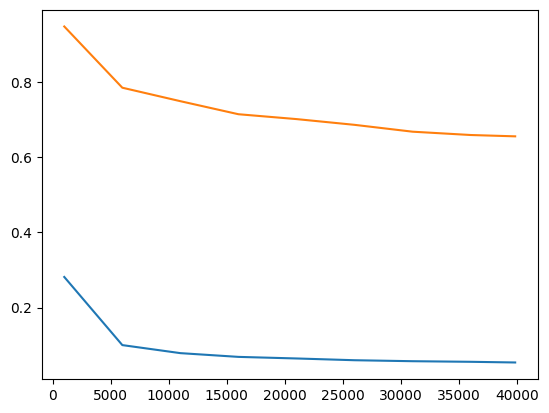

In [25]:
sns.lineplot(x=splits, y=word_errors)
sns.lineplot(x=splits, y=sent_errors)